In [329]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Ridge, LinearRegression

In [36]:
data = pd.read_csv('data.csv')

In [37]:
data.set_index('OSEBuildingID', inplace = True)

In [38]:
data

,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),EnergyStarNaN,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyGFAParking(%),PropertyGFABuilding(s)(%),SteamUse(%),Electricity(%),NaturalGas(%),PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12,88434,88434.0,60.0,81.699997,84.300003,182.500000,189.000000,0,7.226362e+06,7.456910e+06,249.98,2.83,89,0.000000,100.000000,27.730162,54.605993,17.663838,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1.0,11,103566,83880.0,61.0,94.800003,97.900002,176.100006,179.399994,0,8.387933e+06,8.664479e+06,295.86,2.86,20,14.545314,85.454686,0.000000,38.660907,61.339093,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,41,956110,756493.0,43.0,96.000000,97.699997,241.899994,244.100006,0,7.258702e+07,7.393711e+07,2089.28,2.19,47,20.574829,79.425171,29.711308,68.230741,2.057944,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1.0,10,61320,61320.0,56.0,110.800003,113.300003,216.199997,224.000000,0,6.794584e+06,6.946800e+06,286.43,4.67,90,0.000000,100.000000,32.591344,40.751928,26.656717,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1.0,18,175580,123445.0,75.0,114.800003,118.699997,211.399994,215.600006,0,1.417261e+07,1.465650e+07,505.01,2.88,36,35.311539,64.688461,0.000000,37.880168,62.119825,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50222,1.0,1,12294,12294.0,46.0,69.099998,76.699997,161.699997,176.100006,0,8.497457e+05,9.430032e+05,20.94,1.70,26,0.000000,100.000000,0.000000,61.697384,38.302639,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
50223,1.0,1,16000,16000.0,0.0,59.400002,65.900002,114.199997,118.900002,1,9.502762e+05,1.053706e+06,32.17,2.01,12,0.000000,100.000000,0.000000,41.729558,58.270426,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
50224,1.0,1,13157,7583.0,0.0,438.200012,460.100006,744.799988,767.799988,1,5.765898e+06,6.053764e+06,223.54,16.99,42,0.000000,100.000000,0.000000,31.082041,68.917956,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
data.loc[data['SourceEUI(kBtu/sf)'].isnull()]

,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),EnergyStarNaN,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,Age,PropertyGFAParking(%),PropertyGFABuilding(s)(%),SteamUse(%),Electricity(%),NaturalGas(%),PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
773,1.0,4,63150,63150.0,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,92,0.0,100.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
26532,1.0,2,20760,20760.0,0.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,88,0.0,100.0,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [40]:
data.loc[data['TotalGHGEmissions'].isnull(), 'TotalGHGEmissions'] = np.mean(data['TotalGHGEmissions'])

In [41]:
data.loc[data['GHGEmissionsIntensity'].isnull(), 'GHGEmissionsIntensity'] = np.mean(data['GHGEmissionsIntensity'])

In [42]:
data.columns

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'EnergyStarNaN', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Age',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)', 'SteamUse(%)',
       'Electricity(%)', 'NaturalGas(%)',
       'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'P

In [43]:
X = data[['Age','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking(%)',
        'PropertyGFABuilding(s)(%)','LargestPropertyUseTypeGFA','ENERGYSTARScore','EnergyStarNaN',
        'PrimaryPropertyType_Distribution Center', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_K-12 School', 
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility','CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'CouncilDistrictCode_7']]


y = data['TotalGHGEmissions']

In [44]:
X.head()

,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking(%),PropertyGFABuilding(s)(%),LargestPropertyUseTypeGFA,ENERGYSTARScore,EnergyStarNaN,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Other,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,89,1.0,12,88434,0.000000,100.000000,88434.0,60.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,20,1.0,11,103566,14.545314,85.454686,83880.0,61.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,47,1.0,41,956110,20.574829,79.425171,756493.0,43.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,90,1.0,10,61320,0.000000,100.000000,61320.0,56.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,36,1.0,18,175580,35.311539,64.688461,123445.0,75.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
std_scale = StandardScaler().fit(X)
X_scale = std_scale.transform(X)

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state = 17)

In [295]:
X_test.shape

(330, 30)

In [296]:
dr = DummyRegressor(strategy="mean")

In [297]:
dr.fit(X_train, y_train)

DummyRegressor()

In [298]:
dr.score(X_test, y_test)

-0.0006689878529229087

In [299]:
baseline_error = mean_squared_error(y_test, dr.predict(y_test), squared=False)

In [300]:
baseline_error

723.4215605467824

In [301]:
lr = LinearRegression()

In [302]:
lr.fit(X_train, y_train)

LinearRegression()

In [303]:
mean_squared_error(y_test, lr.predict(X_test), squared=False)

1782.8557251654645

In [304]:
n_alphas = 100
alphas = np.logspace(-1, 6, n_alphas)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, mean_squared_error(y_test, ridge.predict(X_test), squared=False)])

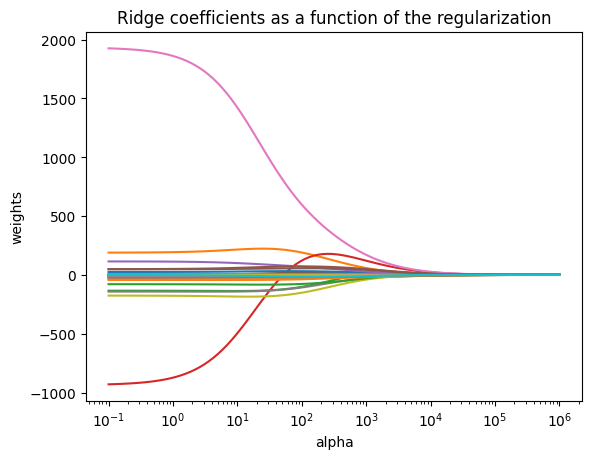

In [305]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

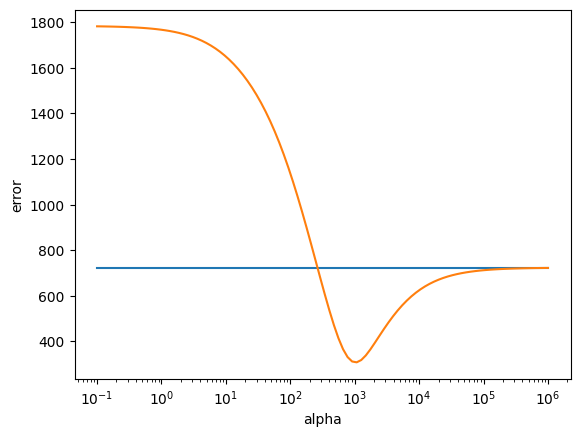

In [306]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [307]:
np.min(errors)

308.6233801711987

In [308]:
errors.index(min(errors))

57

In [309]:
errors[errors.index(min(errors))]

[723.4215605467824, 308.6233801711987]

In [310]:
alphas[errors.index(min(errors))]

1072.2672220103232

In [311]:
ridge.set_params(alpha = alphas[errors.index(min(errors))])
ridge.fit(X_train, y_train)

Ridge(alpha=1072.2672220103232)

In [312]:
mean_squared_error(y_test, ridge.predict(X_test), squared=False)

308.6233801711987

In [321]:
n_alphas = 100
alphas = np.logspace(-1, 3, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

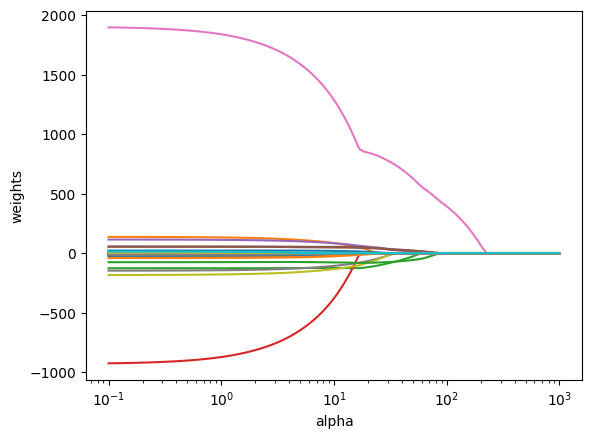

In [322]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

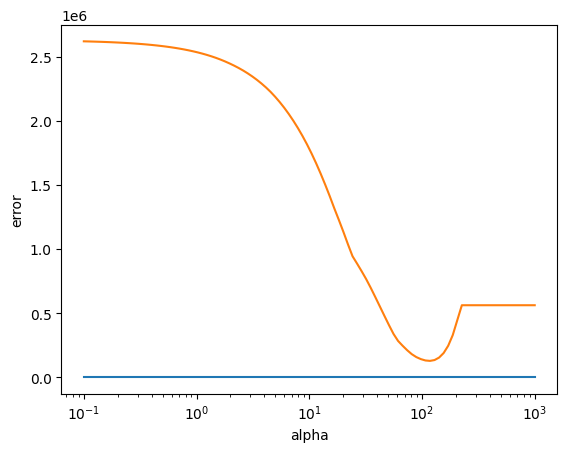

In [323]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [324]:
np.min(errors)

723.4215605467824

In [325]:
errors.index(min(errors))

76

In [326]:
alphas[errors.index(min(errors))]

117.68119524349991

In [327]:
lasso.set_params(alpha = alphas[errors.index(min(errors))])
lasso.fit(X_train, y_train)

Lasso(alpha=117.68119524349991, fit_intercept=False)

In [328]:
mean_squared_error(y_test, lasso.predict(X_test), squared=False)

359.3335202221709

In [333]:
X.columns.values

array(['Age', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'EnergyStarNaN',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Other', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyType_Warehouse',
       'PrimaryPropertyType_Worship Facility', 'CouncilDistrictCode_1',
       'CouncilDistrictCode_2', 'CouncilDistrictCode_3',
       'CouncilDistrictCode_4', 'CouncilDistrictCode_5',
       'CouncilDistrictCode_6', 'Cou

In [341]:
hyperparam = {"Var": X.columns.values, 'alphas': np.logspace(-1, 6, 100)}

In [344]:
grid = GridSearchCV(Ridge(), hyperparam, cv = 10, scoring = 'accuracy')

In [345]:
grid.fit(X_train, y_train)

TypeError: Parameter grid is not a dict (0.1)